In [1]:
!conda install -q -y gdown

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.10.0      |     pyha770c72_0          77 KB  conda-forge
    certifi-2021.10.8          |   py37h89c1867_2         145 KB  conda-forge
    conda-4.12.0               |   py37h89c1867_0         1.0 MB  conda-forge
    filelock-3.6.0             |     pyhd8ed1ab_0          12 KB  conda-forge
    gdown-4.4.0                |     pyhd8ed1ab_0          16 KB  conda-forge
    openssl-1.1.1n             |       h166bdaf_0         2.1 MB  conda-forge
    soupsieve-2.3.1            |     pyhd8ed1ab_0          33 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.4 MB

The following NEW packages will be INSTALLE

In [2]:
!gdown http://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A
!unzip -q dataset.zip

Downloading...
From: http://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 1.13G/1.13G [00:04<00:00, 260MB/s]


In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import math
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn import  model_selection
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        
set_seed(42)

# Hyperparameters (Kindly change the path of the model's weight according to where you have stored)

In [5]:
image_size = 150
#path to best model weights
path = '../input/common-task/Val_acc 0.9688.pth'

In [6]:
def func(path,class_name):
    if(class_name == 'no'):
        ss = 1
    elif(class_name == 'sphere'):
        ss = 0
    else:
        ss = -1
    xx = np.array(os.listdir(path))
    xx = ['./dataset/train/' + f'{class_name}/'+ i for  i in xx]
    xx = np.array(xx)
    xx = np.expand_dims(xx,1)
    yy = np.ones((len(xx),1)) - ss
    gg = np.concatenate([xx,yy],axis = 1)
    return gg

In [7]:
train_path1 = './dataset/train/no'
train_path2 = './dataset/train/sphere'
train_path3 = './dataset/train/vort'

In [8]:
d1 = func(train_path1 , 'no')
d2 = func(train_path2 , 'sphere')
d3 = func(train_path3 , 'vort')

In [9]:
t_data = np.concatenate([d1,d2,d3] , axis = 0)

In [10]:
X_train, X_test = train_test_split(t_data, test_size=0.1, random_state=42)

In [11]:
#make sure the sahpe is (no. of samples x 2)
X_test.shape

(3000, 2)

In [12]:
class Dense_layer(nn.Module):
    def __init__(self,in_chans):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(in_chans),
            nn.PReLU(),
            nn.Conv2d(in_chans, in_chans, kernel_size=1, padding=1, bias=False),
            nn.BatchNorm2d(in_chans),
            nn.PReLU(),
            nn.Conv2d(in_chans, in_chans*2, kernel_size=3, bias=False)
        )
    def forward(self,x):
        return self.net(x)
class Dense_block(nn.Module):
    def __init__(self,in_chans):
        super().__init__()
        self.d1 = Dense_layer(in_chans)
        self.d2 = Dense_layer(in_chans+in_chans*2)
    def forward(self,x):
        op1 = self.d1(x)
        op1 = torch.cat([op1,x],dim =1)
        op2 = self.d2(op1)
        return op2
class TransitionLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            nn.PReLU(),
            nn.Conv2d(c_in, c_out, kernel_size=1,stride=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2) # Average the output for each 2x2 pixel group
        )

    def forward(self, x):
        return self.transition(x)
class Channel_A_Block(nn.Module):
    def __init__(self,in_chans):
        super().__init__()
        self.n = in_chans
        self.maxpool = nn.AdaptiveMaxPool2d((1))
        self.avgpool = nn.AdaptiveAvgPool2d((1))
        self.MLP = nn.Sequential(
            nn.Linear(self.n ,64 ,bias=False),
            nn.PReLU(),
            nn.Linear( 64, self.n,bias=False)
        )
    def forward(self,x):
        x_m = self.maxpool(x)
        x_m = x_m.view(x_m.shape[0],-1)
        x_a = self.avgpool(x)
        x_a = x_a.view(x_a.shape[0],-1)

        x_m = self.MLP(x_m)
        x_a = self.MLP(x_a)

        out = x_m + x_a
        out = out.view(out.shape[0],self.n,1,1)
        out = F.sigmoid(out)

        return out
class Spatial_A_Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxp = nn.AdaptiveMaxPool3d((1,None,None))
        self.avgp = nn.AdaptiveMaxPool3d((1,None,None))
        self.conv = nn.Conv2d(2 , 1 , 7, padding=7//2, bias=False)
     
    def forward(self,x):
        x_m = self.maxp(x)
        x_a = self.avgp(x)
        op = torch.cat([x_m , x_a] , dim =1)
        op = F.sigmoid(self.conv(op))
        return op
class A_Block(nn.Module):
    def __init__(self,in_chans):
        super().__init__()
        self.c_a = Channel_A_Block(in_chans)
        self.s_a = Spatial_A_Block()

    def forward(self,x):
        Fc = self.c_a(x)
        Fc = Fc*x
        Fm = self.s_a(Fc)
        F = Fm*Fc
        return F

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(1,4, kernel_size=3)
        
        self.dense_block1 = Dense_block(4)
        self.a_b1 = A_Block(24) #inchans = 2*(prev_chans + 2*prev_chans) hence (2*(4 + 2*4)) = 24)
        self.tras1 = TransitionLayer(24 , 32)
        
        self.dense_block2 = Dense_block(32)
        self.a_b2 = A_Block(192) # (2*(32 + 2*32)) = 192
        self.tras2 = TransitionLayer(192 , 360)


        self.pool = nn.AdaptiveAvgPool2d((1))
        self.neck = nn.Sequential(
            nn.Linear(360,360,bias =False),
            nn.ReLU(),
            nn.BatchNorm1d(360),
            nn.Linear(360 , 64,bias =False),
            nn.BatchNorm1d(64),
            nn.Linear(64,3)
        )
        
    def forward(self,x):
        x = self.conv1(x)
        
        x = self.dense_block1(x)
        x = self.a_b1(x)
        x = self.tras1(x)
        
        x = self.dense_block2(x)
        x = self.a_b2(x)
        x = self.tras2(x)
    
        
        x = self.pool(x)
        x = x.view(x.shape[0],-1)
        x = self.neck(x)
        return x

In [14]:
image_size = 150
test_aug = A.Compose(
        [  
        A.Resize(image_size,image_size,p=1.0),    
        ToTensorV2()
        ]
        )

In [15]:
class Len(Dataset):
    def __init__(self , data , augs):
        self.data = data
        self.augs = augs
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self , idx):
        
        img_src = self.data[idx][0]
        
        image = np.load(img_src)
        image = image - 0.5
        image = np.squeeze(image, axis = 0)
        transformed = self.augs(image=image)       
        image = transformed['image']
        image = torch.tensor(image,dtype = torch.float32) 

        return image

In [16]:
test_data= Len(X_test , augs = test_aug)
test_loader = DataLoader(test_data,
                             shuffle=False,
                        batch_size=64)

In [17]:
def inference_func(test_loader):
    model = Model()
    model = model.to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    bar = tqdm(test_loader)
    
    PREDS = []
    
    with torch.no_grad():
        for batch_idx, images in enumerate(bar):
            x = images.to(device)
            logits = model(x)
            PREDS += [torch.softmax(logits, 1).detach().cpu()]
        PREDS = torch.cat(PREDS).cpu().numpy()
    
    return PREDS

In [18]:
y_score = inference_func(test_loader)

  0%|          | 0/47 [00:00<?, ?it/s]

In [19]:
y_test = [float(ww) for ww in X_test[: , -1]]
y_test=np.asarray(y_test).reshape(-1)
y_test=label_binarize(y_test, classes=[0, 1, 2])

# Results on test data

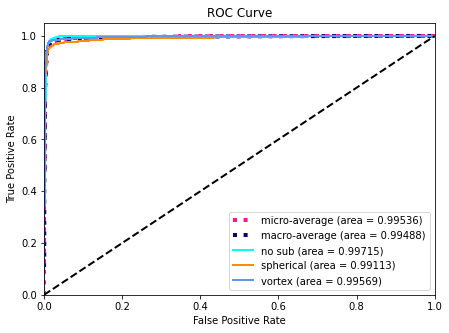

In [20]:
#y_score -> predicted by model
#y_test -> real labels

#plotting code taken from https://github.com/ML4SCI/ML4SCIHackathon/blob/main/GravitationalLensingChallenge/StrongLensingChallenge-Classification.ipynb

n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['no sub', 'spherical', 'vortex']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))

# Plot the ROC 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={"size":10})
plt.show()

In [21]:
# deleting data after use
import shutil
shutil.rmtree("./dataset/")